In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("example").getOrCreate()
df = spark.read.csv("hdfs://localhost:9000/user/hduser/project_tweets/ProjectTweets.csv", header=True, inferSchema=True)

df.show()



+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  1|1467810672|        Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|                                                                                               is upset that he ...|
|  2|1467810917|        Mon Apr 06 22:19:...|NO_QUERY|       mattycus|                                                                                               @Kenichan I dived...|
|  3|1467811184|        Mon Apr 06 22:19:...|NO_QUERY|        Ell

In [3]:
from pyspark.sql import SparkSession

# Spark session
spark = SparkSession.builder.appName("sample_tweets").getOrCreate()

# CSV file from HDFS into a PySpark DataFrame
df = spark.read.csv("hdfs://localhost:9000/user/hduser/project_tweets/ProjectTweets.csv", header=True, inferSchema=True)

# the number of rows in the original dataset
print("Original dataset size:", df.count())

# Sample 1/1000th of the data
sampled_df = df.sample(withReplacement=False, fraction=0.001, seed=42)

#the number of rows in the sampled dataset
print("Sampled dataset size:", sampled_df.count())



Original dataset size: 1599999


Sampled dataset size: 1647


In [5]:
from pyspark.sql.functions import col

# Checking for missing values in the entire DataFrame
missing_counts = [df.filter(col("`{}`".format(c)).isNull()).count() for c in df.columns]

# Counting of missing values for each column
for col_name, missing_count in zip(df.columns, missing_counts):
    print(f"Number of missing values in '{col_name}': {missing_count}")



Number of missing values in '0': 0
Number of missing values in '1467810369': 0
Number of missing values in 'Mon Apr 06 22:19:45 PDT 2009': 0
Number of missing values in 'NO_QUERY': 0
Number of missing values in '_TheSpecialOne_': 0
Number of missing values in '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D': 0


In [6]:
df.show()


+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  1|1467810672|        Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|                                                                                               is upset that he ...|
|  2|1467810917|        Mon Apr 06 22:19:...|NO_QUERY|       mattycus|                                                                                               @Kenichan I dived...|
|  3|1467811184|        Mon Apr 06 22:19:...|NO_QUERY|        Ell

In [7]:
df.describe().show()

+-------+------------------+--------------------+----------------------------+--------+--------------------+-------------------------------------------------------------------------------------------------------------------+
|summary|                 0|          1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|     _TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+-------+------------------+--------------------+----------------------------+--------+--------------------+-------------------------------------------------------------------------------------------------------------------+
|  count|           1599999|             1599999|                     1599999| 1599999|             1599999|                                                                                                            1599999|
|   mean|          800000.0|1.9988178841753244E9|                        null|    null| 4.3258875218

In [8]:
#The column names in the DataFrame
df.columns


['0',
 '1467810369',
 'Mon Apr 06 22:19:45 PDT 2009',
 'NO_QUERY',
 '_TheSpecialOne_',
 "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]

In [13]:
from pyspark.ml.feature import Tokenizer, CountVectorizer
from pyspark.sql.functions import length, col

# Convert column '0' to string type
df = df.withColumn('0', col('0').cast('string'))

# Tokenizing the text
tokenizer = Tokenizer(inputCol='0', outputCol='words')
df_words = tokenizer.transform(df)

# Counting vectorize the words
cv = CountVectorizer(inputCol='words', outputCol='word_vector')
cv_model = cv.fit(df_words)
df_word_vector = cv_model.transform(df_words)

# The most common words
df_word_vector.select('word_vector').show()

# Calculating the length of each tweet
df_with_length = df.withColumn('text_length', length(col('0')))
df_with_length.show()


2023-11-22 17:31:35,600 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 2.4 MiB


+--------------------+
|         word_vector|
+--------------------+
|      (262144,[],[])|
|      (262144,[],[])|
|      (262144,[],[])|
|      (262144,[],[])|
|      (262144,[],[])|
|(262144,[171547],...|
|      (262144,[],[])|
|(262144,[58838],[...|
|      (262144,[],[])|
|      (262144,[],[])|
|(262144,[213714],...|
|      (262144,[],[])|
|      (262144,[],[])|
|      (262144,[],[])|
|      (262144,[],[])|
|      (262144,[],[])|
|      (262144,[],[])|
|      (262144,[],[])|
|(262144,[156260],...|
|      (262144,[],[])|
+--------------------+
only showing top 20 rows

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+-----------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|text_length|
+---+----------+--------

In [14]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Define a function for sentiment analysis using VADER
def analyze_sentiment(text):
    # Use VADER to get the compound sentiment score
    sentiment_score = sid.polarity_scores(text)['compound']
    
    # Classify the sentiment based on the compound score
    if sentiment_score >= 0.05:
        return 'positive'
    elif sentiment_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Create a UDF (User Defined Function) for the sentiment analysis
analyze_sentiment_udf = udf(analyze_sentiment, StringType())

# Apply the UDF to the DataFrame to get sentiment scores
df_with_sentiment = df_with_length.withColumn('sentiment_score', analyze_sentiment_udf('0'))

# Display the DataFrame with sentiment scores
df_with_sentiment.select('0', 'text_length', 'sentiment_score').show()


+---+-----------+---------------+
|  0|text_length|sentiment_score|
+---+-----------+---------------+
|  1|          1|        neutral|
|  2|          1|        neutral|
|  3|          1|        neutral|
|  4|          1|        neutral|
|  5|          1|        neutral|
|  6|          1|        neutral|
|  7|          1|        neutral|
|  8|          1|        neutral|
|  9|          1|        neutral|
| 10|          2|        neutral|
| 11|          2|        neutral|
| 12|          2|        neutral|
| 13|          2|        neutral|
| 14|          2|        neutral|
| 15|          2|        neutral|
| 16|          2|        neutral|
| 17|          2|        neutral|
| 18|          2|        neutral|
| 19|          2|        neutral|
| 20|          2|        neutral|
+---+-----------+---------------+
only showing top 20 rows



In [15]:
df_sentiment_distribution = df_with_sentiment.groupBy('sentiment_score').count()
df_sentiment_distribution.show()


+---------------+-------+
|sentiment_score|  count|
+---------------+-------+
|       positive|      3|
|        neutral|1599993|
|       negative|      3|
+---------------+-------+



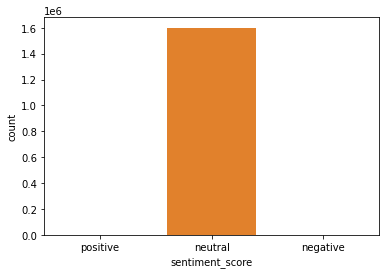

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Converting Spark DataFrame to Pandas DataFrame for visualization
pd_sentiment_distribution = df_sentiment_distribution.toPandas()

# Plot the sentiment distribution
sns.barplot(x='sentiment_score', y='count', data=pd_sentiment_distribution)
plt.show()


In [17]:
# examples of texts with positive sentiment
df_with_sentiment.filter(col('sentiment_score') == 'positive').select('0').show()

# examples of texts with negative sentiment
df_with_sentiment.filter(col('sentiment_score') == 'negative').select('0').show()

# examples of texts with neutral sentiment
df_with_sentiment.filter(col('sentiment_score') == 'neutral').select('0').show()


+----+
|   0|
+----+
| 143|
|1337|
|1432|
+----+



+---+
|  0|
+---+
| 86|
|182|
|187|
+---+



+---+
|  0|
+---+
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
| 10|
| 11|
| 12|
| 13|
| 14|
| 15|
| 16|
| 17|
| 18|
| 19|
| 20|
+---+
only showing top 20 rows



In [19]:
from pyspark.sql.functions import when


In [23]:
from pyspark.sql.functions import when
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Your existing code...

df_with_sentiment = df_with_sentiment.withColumn(
    'label',
    when(col('sentiment_score') == 'positive', 2)
    .when(col('sentiment_score') == 'neutral', 1)
    .otherwise(0)
)

# Splitted the data into training and testing sets
(training_data, testing_data) = df_with_sentiment.randomSplit([0.8, 0.2], seed=123)

# Defined features (assuming 'word_vector' is the column with vectorized words)
assembler = VectorAssembler(inputCols=['word_vector'], outputCol='features')

# Created a Logistic Regression model
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, labelCol='label')

# Created a pipeline to assemble features and train the model
pipeline = Pipeline(stages=[assembler, lr])

# Trained the model
model = pipeline.fit(training_data)

# Making predictions on the testing data
predictions = model.transform(testing_data)

# Evaluated the model
evaluator = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='accuracy'
)

accuracy = evaluator.evaluate(predictions)
print(f"Accuracy of the sentiment analysis model: {accuracy}")


IllegalArgumentException: word_vector does not exist. Available: 0, 1467810369, Mon Apr 06 22:19:45 PDT 2009, NO_QUERY, _TheSpecialOne_, @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D, text_length, sentiment_score, label

In [24]:
# Defining features
assembler = VectorAssembler(inputCols=['vectorized_words'], outputCol='features')


In [25]:
df_with_sentiment.printSchema()


root
 |-- 0: string (nullable = true)
 |-- 1467810369: long (nullable = true)
 |-- Mon Apr 06 22:19:45 PDT 2009: string (nullable = true)
 |-- NO_QUERY: string (nullable = true)
 |-- _TheSpecialOne_: string (nullable = true)
 |-- @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D: string (nullable = true)
 |-- text_length: integer (nullable = true)
 |-- sentiment_score: string (nullable = true)
 |-- label: integer (nullable = false)



In [27]:
from pyspark.ml.feature import Tokenizer, CountVectorizer
from pyspark.sql.functions import when, col

text_column = df.columns[-1]

df = df.withColumn(
    'label',
    when(col('sentiment_score') == 'positive', 2)
    .when(col('sentiment_score') == 'neutral', 1)
    .otherwise(0)
)

# Tokenizing the text
tokenizer = Tokenizer(inputCol=text_column, outputCol='words')
df = tokenizer.transform(df)

# Counting Vectorization
vectorizer = CountVectorizer(inputCol='words', outputCol='text_vector')
vector_model = vectorizer.fit(df)
df = vector_model.transform(df)


AnalysisException: cannot resolve '`sentiment_score`' given input columns: [0, 1467810369, @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D, Mon Apr 06 22:19:45 PDT 2009, NO_QUERY, _TheSpecialOne_];
'Project [0#725, 1467810369#126L, Mon Apr 06 22:19:45 PDT 2009#127, NO_QUERY#128, _TheSpecialOne_#129, @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D#130, CASE WHEN ('sentiment_score = positive) THEN 2 WHEN ('sentiment_score = neutral) THEN 1 ELSE 0 END AS label#934]
+- Project [cast(0#125 as string) AS 0#725, 1467810369#126L, Mon Apr 06 22:19:45 PDT 2009#127, NO_QUERY#128, _TheSpecialOne_#129, @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D#130]
   +- Relation[0#125,1467810369#126L,Mon Apr 06 22:19:45 PDT 2009#127,NO_QUERY#128,_TheSpecialOne_#129,@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D#130] csv


In [28]:
df.printSchema()

root
 |-- 0: string (nullable = true)
 |-- 1467810369: long (nullable = true)
 |-- Mon Apr 06 22:19:45 PDT 2009: string (nullable = true)
 |-- NO_QUERY: string (nullable = true)
 |-- _TheSpecialOne_: string (nullable = true)
 |-- @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D: string (nullable = true)



In [30]:

df_with_sentiment = df_with_length.withColumn('sentiment_score', analyze_sentiment_udf(col('0')))


In [32]:
df_with_label = df_with_sentiment.withColumn(
    'label',
    when(col('sentiment_score') == 'positive', 2)
    .when(col('sentiment_score') == 'neutral', 1)
    .otherwise(0)
)


In [35]:
from pyspark.ml.feature import Tokenizer, CountVectorizer, VectorAssembler
from pyspark.sql.functions import when, col


df = df.withColumn(
    'label',
    when(col('0') == 'positive', 2)
    .when(col('0') == 'neutral', 1)
    .otherwise(0)
)

# Tokenizing the text
tokenizer = Tokenizer(inputCol='0', outputCol='words')
df = tokenizer.transform(df)

#Vectorization
vectorizer = CountVectorizer(inputCol='words', outputCol='text_vector')
vector_model = vectorizer.fit(df)
df = vector_model.transform(df)

assembler = VectorAssembler(inputCols=['text_vector'], outputCol='features')
df = assembler.transform(df)


IllegalArgumentException: Output column words already exists.

In [39]:
from pyspark.ml.feature import VectorAssembler

# 'features' is the column with vectorized words
assembler = VectorAssembler(inputCols=['features'], outputCol='feature_vector')
train_df = assembler.transform(training_data)

# 'train_df' contains a new column 'feature_vector' with the assembled features

# Defining and fitting the Logistic Regression model
lr = LogisticRegression(labelCol="label", featuresCol="feature_vector", maxIter=10)
model = lr.fit(train_df)


IllegalArgumentException: features does not exist. Available: 0, 1467810369, Mon Apr 06 22:19:45 PDT 2009, NO_QUERY, _TheSpecialOne_, @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D, text_length, sentiment_score, label

In [40]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


In [41]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=30)
model = rf.fit(train_df)


2023-11-22 17:46:33,502 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 17.8 MiB
2023-11-22 17:46:57,587 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 17.8 MiB
2023-11-22 17:47:12,294 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 17.8 MiB
2023-11-22 17:47:32,896 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 20.4 MiB
2023-11-22 17:49:40,037 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1034.3 KiB
2023-11-22 17:49:41,617 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 22.4 MiB
2023-11-22 17:50:03,562 WARN memory.MemoryStore: Not enough space to cache rdd_258_0 in memory! (computed 272.9 MiB so far)
2023-11-22 17:50:03,581 WARN storage.BlockManager: Persisting block rdd_258_0 to disk instead.


KeyboardInterrupt: 

In [42]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SentimentApp") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


In [43]:
df_time_aggregated_week = df_with_sentiment.groupBy(date_format(df_with_sentiment.columns[2], 'yyyy-MM-dd').alias('week')).agg({'sentiment_score': 'avg'})



NameError: name 'date_format' is not defined

In [44]:
df_with_sentiment.persist()


DataFrame[0: string, 1467810369: bigint, Mon Apr 06 22:19:45 PDT 2009: string, NO_QUERY: string, _TheSpecialOne_: string, @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D: string, text_length: int, sentiment_score: string]

In [45]:
from pyspark.sql.functions import date_format, quarter

df_time_aggregated_week = df_with_sentiment.groupBy(date_format(df_with_sentiment.columns[2], 'yyyy-MM-dd').alias('week')).agg({'sentiment_score': 'mean'})

df_time_aggregated_month = df_with_sentiment.groupBy(date_format(df_with_sentiment.columns[2], 'yyyy-MM').alias('month')).agg({'sentiment_score': 'mean'})

df_time_aggregated_3months = df_with_sentiment.groupBy(quarter(df_with_sentiment.columns[2]).alias('quarter')).agg({'sentiment_score': 'mean'})



In [50]:
df_with_sentiment.persist()


2023-11-22 18:17:16,862 WARN execution.CacheManager: Asked to cache already cached data.


DataFrame[0: string, 1467810369: bigint, Mon Apr 06 22:19:45 PDT 2009: string, NO_QUERY: string, _TheSpecialOne_: string, @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D: string, text_length: int, sentiment_score: string]

In [ ]:
df_time_aggregated_week.show()
df_time_aggregated_month.show()
df_time_aggregated_3months.show()


In [2]:
pip install torch




SyntaxError: invalid syntax (2789471359.py, line 1)

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Extracting sentiment scores and scaling the data
sentiment_data = df_time_aggregated_week.select('sentiment_score').toPandas()
scaler = MinMaxScaler()
sentiment_data_scaled = scaler.fit_transform(sentiment_data)

# Converting the data into sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return sequences

# Hyperparameters
sequence_length = 5
input_size = 1
hidden_size = 100
num_layers = 1
output_size = 1
learning_rate = 0.001
num_epochs = 100

# Preparing data
sequences = create_sequences(sentiment_data_scaled, sequence_length)
X = np.array([item[0] for item in sequences])
y = np.array([item[1] for item in sequences])

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting to PyTorch tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

#LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    mse = mean_squared_error(y_test, test_outputs)
    print(f'Mean Squared Error on Test Data: {mse:.4f}')

# the predictions and true labels to original scale
test_outputs_original = scaler.inverse_transform(test_outputs.numpy())
y_test_original = scaler.inverse_transform(y_test.numpy())

# Plots
plt.figure(figsize=(12, 6))
plt.plot(test_outputs_original, label='Predicted')
plt.plot(y_test_original, label='True')
plt.title('LSTM Time Series Forecasting')
plt.xlabel('Time')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'torch._C'